# Physical Shapes
{term}`GDS Factory` allows us to design photonic devices that can then be sent to a manufacturer. In GDS Factory, we create components and then connect them together to create larger, more complicated designs. Components can be simple shapes, or more complex with references to other components. They usually have ports which allow you to connect the component to other components in GDS Factory. 

## Elements of a Component

Components can be made up of polygons, references, and ports.

A component in GDS Factory can be made like this.


In [136]:
import gdsfactory as gf

PDK = gf.get_generic_pdk()
PDK.activate()

# Our main component
c = gf.Component()

### Basic Polygons
Polygons are the lowest building block of components, and if you print out a component's information, it will tell you how many polygons are contained within it. Since the same polygon is often used twice or multiple times within a component, it will often be referenced.  

Now we can add polygons to our component. We create polygons by passing in tuples of coordinates into the points argument. When specifying points we need to do this in a circular fashion as seen here with these points.

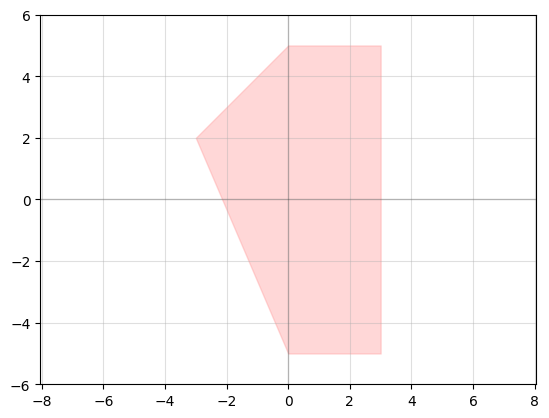

In [137]:
c.add_polygon(points=[(0, 5.0), (3, 5.0), (3.0, -5.0), (0.0, -5.0),(-3.0,2)], layer=1)
c.plot()

To make creating polygons easier we could create a function that that makes the points for us. This function below will help us make shapes with four corners.

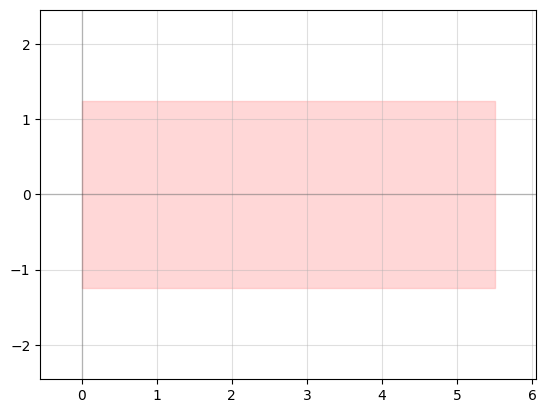

In [138]:
def make_four_points(top_length, left_width, bot_length=None, right_width=None):
    '''
    If we only pass the first two arguments this function will return 
    a list of points that create a polygon with four points. If we put 
    in the other two arguments we can define the size of any of the sizes 
    independently.
    '''
    
    if bot_length is None: bot_length = top_length
    if right_width is None: right_width = left_width
    if top_length >= bot_length: 
        x_offset = top_length
    else:
        x_offset = bot_length
    # The Polygon has to be made in a circular pattern
    points = [
        (-top_length/2+x_offset/2,left_width/2),
        (top_length/2+x_offset/2,right_width/2),
        (bot_length/2+x_offset/2,-right_width/2),
        (-bot_length/2+x_offset/2,-left_width/2)
    ]
    return points

# Now let's use our function

rectangle_length = 5.5
rectangle_width = 2.5

rectangle_points = make_four_points(rectangle_length,rectangle_width)

# Now we have the points to make a rectangle we can create a polygon
rectangle = gf.Component()
rectangle.add_polygon(points=rectangle_points, layer=1)

rectangle.plot()

Now say we want to make a tapered polygon. We can use this function like so.

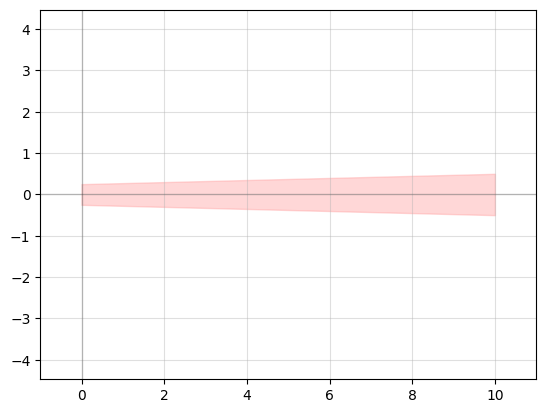

In [139]:
taper_input = 0.5
taper_output = 1
taper_length = 10
taper_gap = 0.125

# Create a new component
taper = gf.Component()

# Use our new polygon function
taper_points = make_four_points(top_length=taper_length, left_width=taper_input, right_width=taper_output)

# Now make a polygon for the taper component
taper.add_polygon(points=taper_points, layer=1)

# Now let's see what the taper looks like
taper.plot()

### References
References to other components within a component, or circuit, are used to save memory as they point to an existing geometry instead of creating a new one. If, for example, you had a component that used the same taper on all of its inputs and outputs, it's easier to create one taper and then reference it in the needed component as many times as you need. So, by using references you can draw on a bank of components to create more complex components without duplicating code and using less memory.

Using references to the taper and rectangle polygons we made above, we can make an {term}`MMI`. If you don't know what a MMI is don't worry we will explain that in a later section. All you need to know now is that it is built with tapers and rectangles.

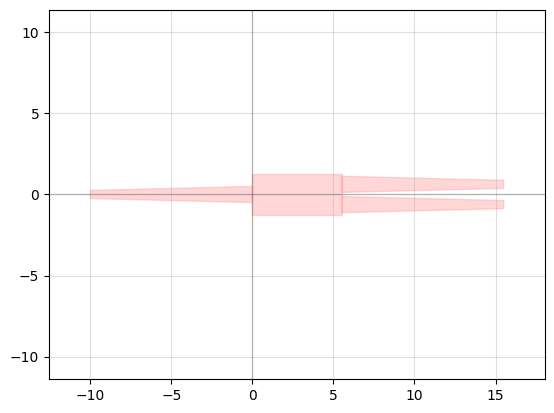

In [131]:
# Create the MMI component that we will add the other components to
mmi = gf.Component()
mmi.add_ref(rectangle)
mmi.add_ref(taper, origin=(-(taper_length),0), rotation=0)
mmi.add_ref(taper, origin=(taper_length+rectangle_length,taper_output/2+taper_gap), rotation=180)
mmi.add_ref(taper, origin=(taper_length+rectangle_length,-(taper_output/2+taper_gap)), rotation=180)

# See the result
mmi.plot()

### Ports
Ports are placed at the inputs and outputs of components, although in a component with many pieces, you can place it at the interconnect between two components. You must specify the direction the port is facing (generally either into or out of the component). You can also specify the width of the port, although it is generally just the width of the input or output of the component it is attached to.  

Ports also make it easier to attach components together. Our MMI was simple so we could manually add tapers to the rectangle by using coordinates. As you make more complex designs and start connecting different components together it might be easier to tell GDS to automatically move and connect the components using ports.

Lets now add ports to our MMI.

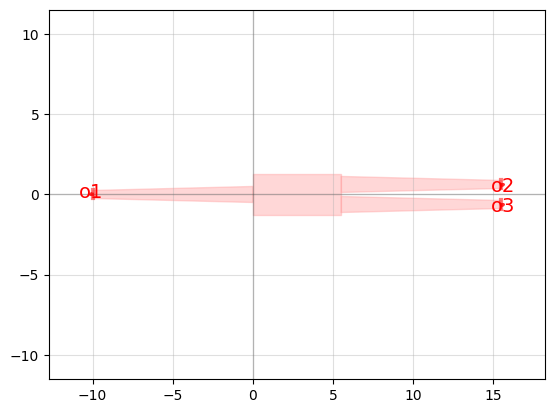

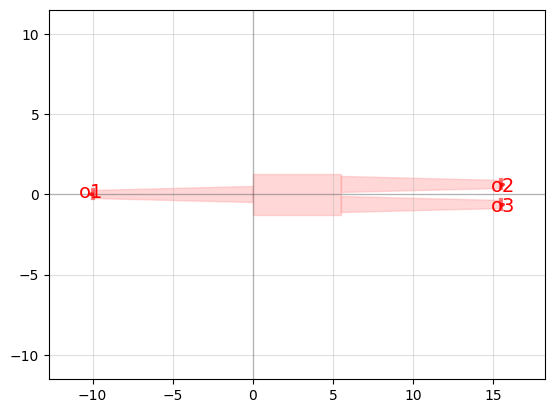

In [132]:
# Add ports to the component
port_width = 0.5
port_center = 0.625
ports = [gf.Port('o1', orientation=180, center=[-taper_length,0], width=port_width, layer=(1, 0), port_type="optical"),
         gf.Port('o2', orientation=0, center=[rectangle_length+taper_length,port_center], width=port_width, layer=(1, 0), port_type="optical"),
         gf.Port('o3', orientation=0, center=[rectangle_length+taper_length,-port_center], width=port_width, layer=(1, 0), port_type="optical")
]
mmi.add_ports(ports)

# Plot the final design
mmi.plot()

# Compare with the GDSFactory component for the 1x2 MMI
gf.components.mmi1x2().plot()

Above we can see how our final design compares to GDS's prebuilt 2x2 MMI. 
#### Connect with ports

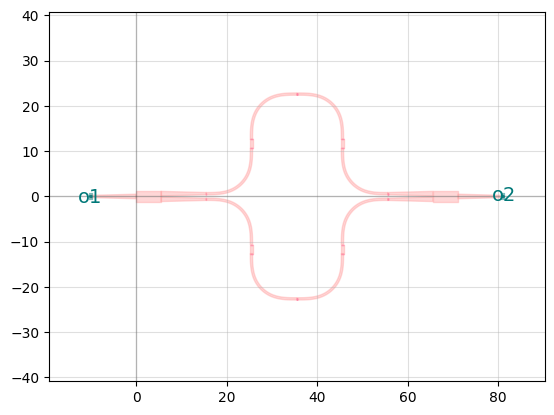

In [133]:
c = gf.Component()

# c << is a shorthand for c.add_ref()
c << gf.components.mzi(delta_length=0)

c.plot()

We can use the MMI created above to create this shape but we also we need some bends and straights.

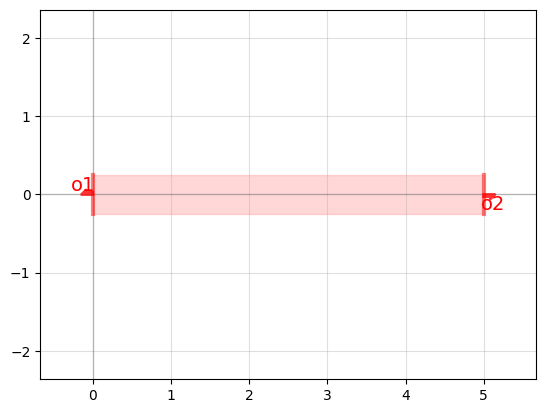

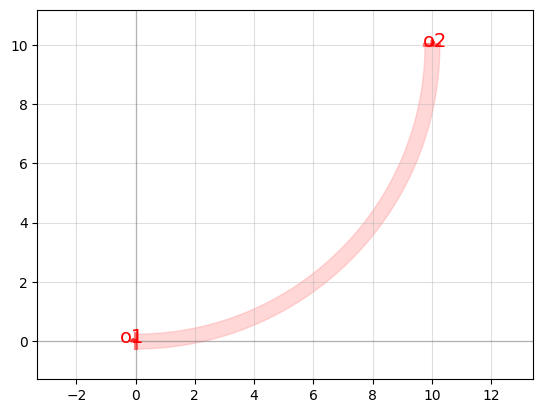

In [134]:
# Make the straight that connects the bends
straight_length = 5
straight_width = taper_input # We want the straight to be the same width as the taper input
my_straight = gf.Component()
my_straight.add_polygon(make_four_points(straight_length, straight_width), layer=1)
# Now add the ports
ports = [gf.Port('o1', orientation=180, center=[0,0], width=straight_width, layer=(1, 0), port_type="optical"),
         gf.Port('o2', orientation=0, center=[straight_length,0], width=straight_width, layer=(1, 0), port_type="optical"),
]
my_straight.add_ports(ports)

# Make a new bend component from GDS components
my_bend = gf.components.bend_circular(layer=(1,0))
# this is all we need to do since the built in GDS components already come with ports

# Plot the results
my_straight.plot()
my_bend.plot()

Now we created all the components we need, we can start connecting them together.

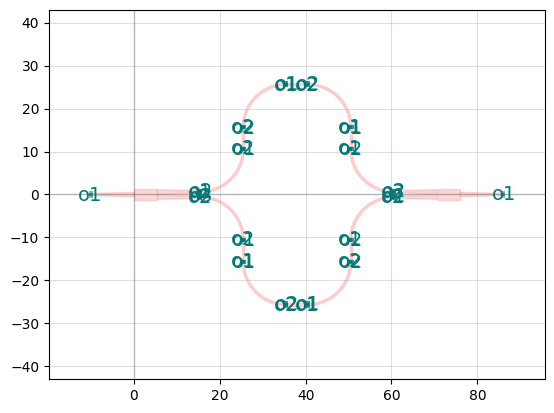

In [135]:
# Create the main MZI component that we will add the other components too
mzi = gf.Component("Custom MZI")

# Add the first MMI
mmi1 = mzi << mmi
# Connect the first bend to the MMI
bend1 = mzi.add_ref(my_bend).connect('o1', mmi.ports['o2'])
straight1 = mzi.add_ref(my_straight).connect('o1', bend1.ports['o2'])
# Connect the second bend
bend2 = mzi.add_ref(my_bend).connect('o2', straight1.ports['o2'])
straight2 = mzi.add_ref(my_straight).connect('o1', bend2.ports['o1'])
# Connect third bend
bend3 = mzi.add_ref(my_bend).connect('o2', straight2.ports['o2'])
straight3 = mzi.add_ref(my_straight).connect('o1', bend3.ports['o1'])
# Connect fourth bend
bend4 = mzi.add_ref(my_bend).connect('o1', straight3.ports['o2'])

# Connect the second 1x2 MMI
mmi2 = mzi.add_ref(mmi).connect('o3', bend4.ports['o2'])
# Connect the fifth bend
bend5 = mzi.add_ref(my_bend).connect('o1', mmi2.ports['o2'])
straight4 = mzi.add_ref(my_straight).connect('o1', bend5.ports['o2'])
# Connect the sixth bend
bend6 = mzi.add_ref(my_bend).connect('o2', straight4.ports['o2'])
straight5 = mzi.add_ref(my_straight).connect('o1', bend6.ports['o1'])
# Connect the seventh bend
bend7 = mzi.add_ref(my_bend).connect('o2', straight5.ports['o2'])
straight6 = mzi.add_ref(my_straight).connect('o1', bend7.ports['o1'])
# Connect the eighth bend
bend8 = mzi.add_ref(my_bend).connect('o1', straight6.ports['o2'])
bend8.connect('o2', mmi1.ports['o3'])

# See the result
mzi.plot()